In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from gymnasium.utils.env_checker import check_env

from flygym import Fly, Camera, SingleFlySimulation

from flygym import Parameters
from flygym.arena import FlatTerrain
from flygym.examples.turning_controller import HybridTurningNMF
from flygym.vision.visualize import save_video_with_vision_insets
from flygym.examples.head_stabilization import HeadStabilizationInferenceWrapper
from flygym.examples.head_stabilization import get_head_stabilization_model_paths
stabilization_model_path, scaler_param_path = get_head_stabilization_model_paths()


In [2]:
class Gratings(FlatTerrain):
    def __init__(
        self,
        n=18,
        height=100,
        distance=12,
        ang_speed=1,
        palette=((0, 0, 0, 1), (1, 1, 1, 1)),
        *args,
        **kwargs,
    ):
        """Creates a circular arena with n cylinders to simulate a grating pattern.

        Parameters
        ----------
        n : int
            Number of cylinders to create.
        height : float
            Height of the cylinders.
        distance : float
            Distance from the center of the arena to the center of the cylinders.
        ang_speed : float
            Angular speed of the cylinders.
        palette : list of tuples
            List of RGBA tuples to use as colors for the cylinders.
        """
        super().__init__(*args, **kwargs)

        self.height = height
        self.ang_speed = ang_speed

        self.cylinders = []
        self.phase = 0
        self.curr_time = 0

        cylinder_material = self.root_element.asset.add(
            "material", name="cylinder", reflectance=0.1
        )

        #########################################################
        # TODO: calculate the radius and the initial positions
        # of the cylinders
        init_pos = np.exp(2j * np.pi * np.arange(n) / n) * distance
        radius = np.abs(init_pos[1] - init_pos[0]) / 2
        #########################################################

        self.init_pos = init_pos

        for i, pos in enumerate(self.init_pos):
            cylinder = self.root_element.worldbody.add(
                "body",
                name=f"cylinder_{i}",
                mocap=True,
                ##################################################
                # TODO: set the position of the cylinder
                pos=(pos.real, pos.imag, self.height / 2),
                ##################################################
            )

            cylinder.add(
                "geom",
                type="cylinder",
                ##################################################
                # TODO: set the size and color of the cylinder
                size=(radius, self.height / 2),
                rgba=palette[i % len(palette)],
                ##################################################
                material=cylinder_material,
            )

            self.cylinders.append(cylinder)

        self.birdeye_cam = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(0, 0, 25),
            euler=(0, 0, 0),
            fovy=45,
        )

    def reset(self, physics):
        """Resets the position of the cylinders and the phase of the grating pattern."""
        self.phase = 0
        self.curr_time = 0

        for i, p in enumerate(self.init_pos):
            physics.bind(self.cylinders[i]).mocap_pos = (
                p.real,
                p.imag,
                self.height / 2,
            )

    def step(self, dt, physics):
        """Steps the phase of the grating pattern and updates the position of the cylinders."""

        if self.curr_time % 1 < 1 / 2:
            self.phase -= dt * self.ang_speed
        else:
            self.phase += dt * self.ang_speed

        self.curr_time += dt

        ##################################################
        # TODO: update the position of the cylinders
        pos = np.exp(self.phase * 1j) * self.init_pos

        for i, p in enumerate(pos):
            physics.bind(self.cylinders[i]).mocap_pos = (
                p.real,
                p.imag,
                self.height / 2,
            )
        ##################################################

In [4]:
optomotor_arena = Gratings() #define arena
aliasign_arena = Gratings(ang_speed = 3750)
adt_arena = Gratings() #adapt to literature description of experiemnts 



arena = aliasign_arena
#build fly body
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

#define simulation parameters
sim_params = Parameters(
    render_playspeed=0.2, #tochange to see speeed
    render_camera="birdeye_cam",
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
    enable_adhesion=True,
    render_window_size=(400, 400),
)

fly = Fly(
        contact_sensor_placements=contact_sensor_placements,
        enable_adhesion=True,
        enable_vision=True,
        vision_refresh_rate=500,
        neck_kp=500,
        head_stabilization_model=Optional[HeadStabilizationInferenceWrapper] = None,
    )
    
nmf = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2), #what is this????
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(70)),
    contact_sensor_placements=contact_sensor_placements,
)

nmf.render()

for i in range(500):
    obs, reward, terminated, truncated, info = nmf.step(np.zeros(2))
    nmf.render()

vision_left = nmf.retina.hex_pxls_to_human_readable(obs["vision"][0, :, :])
vision_right = nmf.retina.hex_pxls_to_human_readable(obs["vision"][1, :, :])

fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
axs[0].imshow(nmf._frames[-1])
axs[1].imshow(vision_left, cmap="gray", vmin=0, vmax=255)
axs[2].imshow(vision_right, cmap="gray", vmin=0, vmax=255)

for ax, title in zip(axs, ["Bird-eye view", "Left eye", "Right eye"]):
    ax.set_title(title)
    ax.axis("off")

SyntaxError: invalid syntax (3873884649.py, line 32)

Shape: (2, 16, 31)


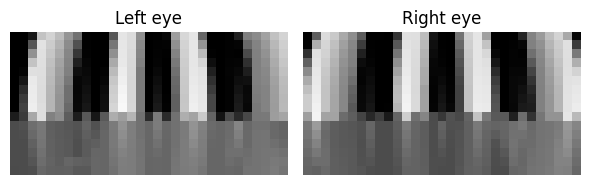

In [24]:
from utils import crop_hex_to_rect

imgs = crop_hex_to_rect(obs["vision"])

fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
axs[0].imshow(imgs[0], cmap="gray", vmin=0, vmax=1)
axs[0].axis("off")
axs[0].set_title("Left eye")
axs[1].imshow(imgs[1], cmap="gray", vmin=0, vmax=1)
axs[1].axis("off")
axs[1].set_title("Right eye")

print("Shape:", imgs.shape)

Text(0.5, 1.0, 'Right eye')

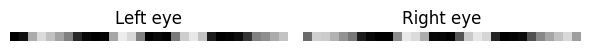

In [25]:
def get_column_responses(visual_input):
    im = crop_hex_to_rect(visual_input)
    return crop_hex_to_rect(visual_input)[:, : im.shape[1] // 2, :].mean(1)


column_responses = get_column_responses(obs["vision"])
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
axs[0].imshow(column_responses[0].reshape((1, -1)), cmap="gray", vmin=0, vmax=1)
axs[0].axis("off")
axs[0].set_title("Left eye")
axs[1].imshow(column_responses[1].reshape((1, -1)), cmap="gray", vmin=0, vmax=1)
axs[1].axis("off")
axs[1].set_title("Right eye")

In [26]:
from numpy.lib.stride_tricks import sliding_window_view


def get_hrc_responses(delayed_intensity, current_intensity):
    """
    Parameters
    ----------
    delayed_intensity : np.ndarray
        Delayed intensities with shape (2, 31).
    current_intensity : np.ndarray
        Current intensities with shape (2, 31).

    Returns
    -------
    np.ndarray
        HRC responses with shape (2, 30).

    """

    #######################################################
    # TODO: calculate the HRC outputs
    return np.cross(
        sliding_window_view(delayed_intensity, 2, axis=-1),
        sliding_window_view(current_intensity, 2, axis=-1),
    )

    # or:
    # return np.linalg.det(
    #     np.stack(
    #         [
    #             sliding_window_view(delayed_intensity, 2, axis=-1),
    #             sliding_window_view(current_intensity, 2, axis=-1),
    #         ],
    #         axis=-2,
    #     )
    # )
    #######################################################

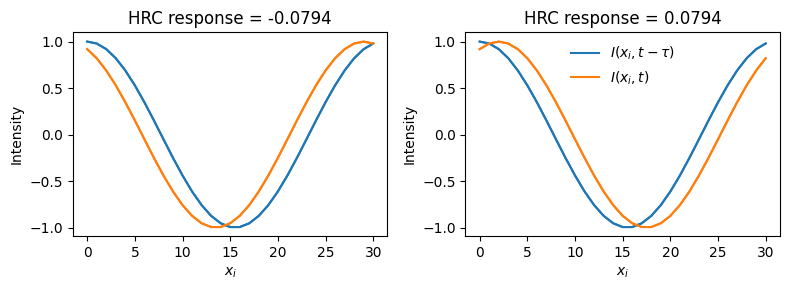

In [27]:
delayed_intensity = np.tile(np.cos(2 * np.pi * np.arange(31) / 31), (2, 1))

fig, axs = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

for ax, shift in zip(axs, (-2, 2)):
    current_intensity = np.roll(delayed_intensity, shift, axis=1)
    ax.plot(delayed_intensity.T, color="C0", label=r"$I(x_i,t-\tau)$")
    ax.plot(current_intensity.T, color="C1", label=r"$I(x_i,t)$")
    ax.set_title(
        f"HRC response = {get_hrc_responses(delayed_intensity, current_intensity).mean():.4f}"
    )
    ax.set_xlabel("$x_i$")
    ax.set_ylabel("Intensity")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::2], labels[::2], loc="upper center", frameon=False)

In [28]:
arena.reset(nmf.physics)
obs, info = nmf.reset(seed=10)

n_delays = 4    # time delay = n_delays * 1 / vision_refresh_rate
col_response_hist = [get_column_responses(obs["vision"])] * n_delays
visual_inputs_hist = []

n_steps_per_vision_refresh = int(
    1 / nmf.sim_params.vision_refresh_rate / nmf.sim_params.timestep
)

for i in trange(10000):
    if i % n_steps_per_vision_refresh == 0:
        delayed_intensity = col_response_hist.pop(0)
        current_intensity = get_column_responses(obs["vision"])
        col_response_hist.append(current_intensity)

        hrc_response = get_hrc_responses(delayed_intensity, current_intensity).mean()

        ######################################################################
        # TODO: Apply turning descending signals of [-1.2, 1.2] or [1.2, -1.2]
        # depending on the motion direction to make the fly turn towards the
        # grating pattern.
        action = np.array([1.2, 1.2])
        action[int(hrc_response > 0)] = -1.2
        ######################################################################

    obs = nmf.step(action)[0]
    render_res = nmf.render()

    if render_res is not None:
        visual_inputs_hist.append(obs["vision"].copy())

save_video_with_vision_insets(nmf, "outputs/optomotor_ang_speed_3750.mp4", visual_inputs_hist)

100%|██████████| 10000/10000 [03:47<00:00, 44.03it/s]
